# Recurrent Neural Networks for Stock Price Prediction, Deep Learning Fundamentals

## Problem Setup and Dataset Preparation

In [3]:
import pandas as pd

# Define file paths
train_path = '/Users/chayonimeu/Documents/GitHub/RNN_GRU_LSTM_-for-_Stock-Price-Prediction/GSP_Data/Google_Stock_Price_Train.csv'
test_path = '/Users/chayonimeu/Documents/GitHub/RNN_GRU_LSTM_-for-_Stock-Price-Prediction/GSP_Data/Google_Stock_Price_Test.csv'

# Load datasets
try:
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    print("Datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}")

# Display data samples
print("\nTraining Data Sample:")
print(train_data.head())
print(train_data.dtypes)

print("\nTesting Data Sample:")
print(test_data.head())
print(test_data.dtypes)

Datasets loaded successfully!

Training Data Sample:
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

Testing Data Sample:
       Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400
Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume     object
dtype: object


### Clean and Preprocess Data

In [4]:
# Clean and preprocess the data
def clean_data(data):
    # Convert 'Date' column to datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Remove commas from 'Close' and 'Volume', and convert to float
    if 'Close' in data.columns and data['Close'].dtype == 'object':
        data['Close'] = data['Close'].str.replace(',', '').astype(float)
    if 'Volume' in data.columns and data['Volume'].dtype == 'object':
        data['Volume'] = data['Volume'].str.replace(',', '').astype(float)
    
    return data

# Apply cleaning
train_data = clean_data(train_data)
test_data = clean_data(test_data)

# Display the cleaned data
print("\nCleaned Training Data Sample:")
print(train_data.head())

print("\nCleaned Testing Data Sample:")
print(test_data.head())


Cleaned Training Data Sample:
        Date    Open    High     Low   Close      Volume
0 2012-01-03  325.25  332.83  324.97  663.59   7380500.0
1 2012-01-04  331.27  333.87  329.08  666.45   5749400.0
2 2012-01-05  329.83  330.75  326.89  657.21   6590300.0
3 2012-01-06  328.34  328.77  323.68  648.24   5405900.0
4 2012-01-09  322.04  322.29  309.46  620.76  11688800.0

Cleaned Testing Data Sample:
        Date    Open    High     Low   Close     Volume
0 2017-01-03  778.81  789.63  775.80  786.14  1657300.0
1 2017-01-04  788.36  791.34  783.16  786.90  1073000.0
2 2017-01-05  786.08  794.48  785.02  794.02  1335200.0
3 2017-01-06  795.26  807.90  792.20  806.15  1640200.0
4 2017-01-09  806.40  809.97  802.83  806.65  1272400.0


### Normalize the Data

In [5]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Define scaler
scaler = MinMaxScaler()

# Select numeric columns for scaling
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Fit scaler on training data and transform both training and testing data
train_scaled = scaler.fit_transform(train_data[numeric_columns])
test_scaled = scaler.transform(test_data[numeric_columns])

# Save the scaler for future use (e.g., inverse transformation)
joblib.dump(scaler, 'scaler.pkl')

# Convert scaled data back to DataFrame for visualization
train_scaled_df = pd.DataFrame(train_scaled, columns=numeric_columns)
test_scaled_df = pd.DataFrame(test_scaled, columns=numeric_columns)

# Display normalized data
print("\nNormalized Training Data Sample:")
print(train_scaled_df.head())

print("\nNormalized Testing Data Sample:")
print(test_scaled_df.head())


Normalized Training Data Sample:
       Open      High       Low     Close    Volume
0  0.085814  0.096401  0.090449  0.237573  0.295258
1  0.097012  0.098344  0.098235  0.241514  0.229936
2  0.094334  0.092517  0.094086  0.228781  0.263612
3  0.091562  0.088819  0.088006  0.216419  0.216179
4  0.079842  0.076718  0.061070  0.178548  0.467797

Normalized Testing Data Sample:
       Open      High       Low     Close    Volume
0  0.929552  0.949484  0.944423  0.406461  0.066055
1  0.947318  0.952677  0.958365  0.407508  0.042655
2  0.943076  0.958541  0.961888  0.417320  0.053156
3  0.960153  0.983603  0.975489  0.434037  0.065370
4  0.980877  0.987469  0.995624  0.434726  0.050641


### Create Time-Series Sequences

In [8]:
import numpy as np

def create_sequences(data, sequence_length, prediction_length):
    """
    Create sequences of data for time-series prediction.
    
    Args:
    - data (array-like): Scaled dataset (e.g., train_scaled or test_scaled).
    - sequence_length (int): Number of past days (N) to use as input.
    - prediction_length (int): Number of future days (M) to predict.

    Returns:
    - X (np.array): Input features with shape (samples, sequence_length, features).
    - y (np.array): Target predictions with shape (samples, prediction_length, features).
    """
    X, y = [], []
    for i in range(len(data) - sequence_length - prediction_length + 1):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length:i + sequence_length + prediction_length])
    return np.array(X), np.array(y)

# Parameters for sequence creation
# Adjusting sequence_length to fit the test dataset (sequence_length + prediction_length <= len(test_scaled))
sequence_length = 19  # Use past 19 days to fit the 20 rows in test data
prediction_length = 1  # Predict next 1 day

# Create sequences for training and testing
X_train, y_train = create_sequences(train_scaled, sequence_length, prediction_length)
X_test, y_test = create_sequences(test_scaled, sequence_length, prediction_length)

# Display shapes
print(f"Training Input Shape: {X_train.shape}")
print(f"Training Target Shape: {y_train.shape}")
print(f"Testing Input Shape: {X_test.shape}")
print(f"Testing Target Shape: {y_test.shape}")

Training Input Shape: (1239, 19, 5)
Training Target Shape: (1239, 1, 5)
Testing Input Shape: (1, 19, 5)
Testing Target Shape: (1, 1, 5)


In [7]:
print(f"Number of rows in test dataset: {len(test_scaled)}")

Number of rows in test dataset: 20


## Model Implementation

### Implement a Vanilla RNN Model

In [9]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# Define the Vanilla RNN model
def build_rnn(sequence_length, num_features):
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dense(units=5))  # Output layer for 5 features
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the model
rnn_model = build_rnn(sequence_length=19, num_features=5)

# Display the model summary
rnn_model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 19, 50)         │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 19, 5)          │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,055 (11.93 KB)

 Trainable params: 3,055 (11.93 KB)

 Non-trainable params: 0 (0.00 B)

### Train the RNN Model

In [12]:
# Train the model
history = rnn_model.fit(
    X_train, y_train,
    validation_split=0.1,  # Use 10% of training data for validation
    epochs=20,
    batch_size=32,
    verbose=0
)

### Evaluate the RNN Model

In [13]:
# Evaluate the model on test data
test_loss = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions
y_pred = rnn_model.predict(X_test)

# Example of inverse scaling for predictions (if necessary)
import joblib

# Load the scaler
scaler = joblib.load('scaler.pkl')

# Reshape and inverse transform predictions
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 5))

print("\nRescaled Predictions:")
print(y_pred_rescaled)

Test Loss: 0.0013279624981805682
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Rescaled Predictions:
[[7.7128894e+02 7.7011694e+02 7.5512567e+02 7.4058575e+02 1.7592080e+06]
 [7.7887140e+02 7.7915570e+02 7.5857587e+02 7.1819794e+02 1.4253562e+06]
 [7.8819885e+02 7.7723627e+02 7.5849280e+02 7.3189880e+02 1.7788820e+06]
 [8.0033167e+02 7.8600476e+02 7.6677228e+02 7.3465924e+02 1.7556474e+06]
 [8.1606793e+02 7.8867145e+02 7.7329260e+02 7.5181775e+02 1.7907560e+06]
 [8.0926678e+02 7.9669214e+02 7.7521472e+02 7.4490601e+02 2.3136820e+06]
 [8.0741003e+02 8.0396564e+02 7.7282281e+02 7.4688019e+02 2.0777215e+06]
 [8.0684918e+02 8.0003442e+02 7.7606976e+02 7.5632507e+02 1.9733105e+06]
 [8.0513647e+02 8.0653674e+02 7.7910541e+02 7.5810278e+02 2.0886008e+06]
 [8.0499158e+02 7.9990247e+02 7.7883899e+02 7.6158325e+02 2.0529656e+06]
 [8.0767670e+02 7.9765332e+02 7.7795532e+02 7.5882489e+02 2.1856570e+06]
 [8.0804663e+02 7.9691205e+02 7.7351068e+02 7.6302899e+02 2.0071569e+06]
 [8.0787805e+02 7.9712250e+02 

### Visualize Results

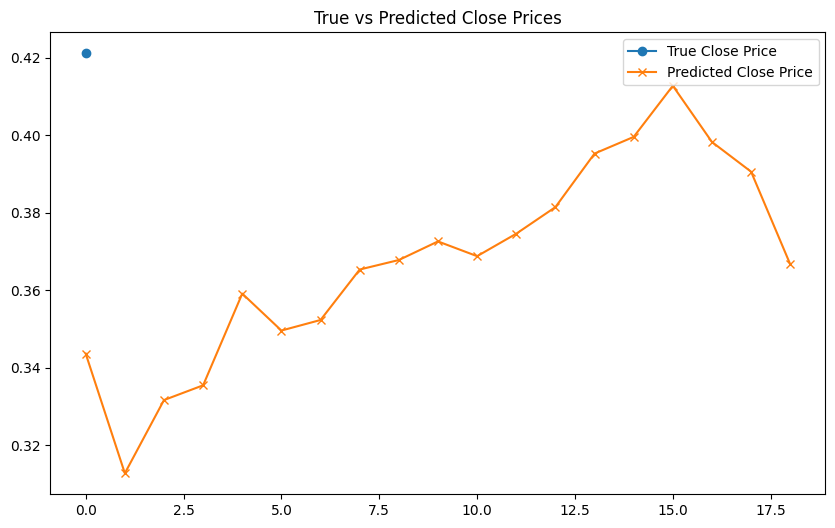

In [14]:
import matplotlib.pyplot as plt

# Plot true vs predicted values for the 'Close' feature
true_close = y_test.reshape(-1, 5)[:, 3]  # Extract true 'Close' values
pred_close = y_pred.reshape(-1, 5)[:, 3]  # Extract predicted 'Close' values

plt.figure(figsize=(10, 6))
plt.plot(true_close, label='True Close Price', marker='o')
plt.plot(pred_close, label='Predicted Close Price', marker='x')
plt.title('True vs Predicted Close Prices')
plt.legend()
plt.show()

## Implement GRU Model

In [15]:
from keras.layers import GRU

# Define the GRU model
def build_gru(sequence_length, num_features):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dense(units=5))  # Output layer for 5 features
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the model
gru_model = build_gru(sequence_length=19, num_features=5)

# Display the model summary
gru_model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 19, 50)         │         8,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19, 5)          │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,805 (34.39 KB)

 Trainable params: 8,805 (34.39 KB)

 Non-trainable params: 0 (0.00 B)

### Train the GRU Model

In [16]:
# Train the GRU model
gru_history = gru_model.fit(
    X_train, y_train,
    validation_split=0.1,  # Use 10% of training data for validation
    epochs=20,
    batch_size=32,
    verbose=0
)

### Evaluate the GRU Model

In [17]:
# Evaluate the model on test data
gru_test_loss = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"GRU Test Loss: {gru_test_loss}")

# Make predictions
gru_y_pred = gru_model.predict(X_test)

# Rescale the predictions (if necessary)
gru_y_pred_rescaled = scaler.inverse_transform(gru_y_pred.reshape(-1, 5))

print("\nGRU Rescaled Predictions:")
print(gru_y_pred_rescaled)

GRU Test Loss: 0.0005800710641779006
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

GRU Rescaled Predictions:
[[7.7942645e+02 7.7283502e+02 7.3898877e+02 7.8185504e+02 9.6367619e+05]
 [7.7632709e+02 7.7491907e+02 7.7351154e+02 7.6148511e+02 2.3276455e+06]
 [7.8190656e+02 7.7837518e+02 7.6608539e+02 7.6669397e+02 1.8318846e+06]
 [7.9563153e+02 7.9050116e+02 7.7617664e+02 7.8383875e+02 1.9813710e+06]
 [8.0093250e+02 7.9238318e+02 7.7938629e+02 7.8393451e+02 1.9956724e+06]
 [8.0085138e+02 7.9213788e+02 7.7899292e+02 7.8214880e+02 2.0137484e+06]
 [7.9849756e+02 7.9109772e+02 7.7757404e+02 7.8431665e+02 2.0421018e+06]
 [7.9777307e+02 7.9171600e+02 7.7700543e+02 7.8554163e+02 2.0925785e+06]
 [8.0093817e+02 7.9338757e+02 7.7956024e+02 7.8581207e+02 2.0268631e+06]
 [7.9712903e+02 7.9087903e+02 7.7665796e+02 7.8451361e+02 2.1068638e+06]
 [7.9648981e+02 7.8992987e+02 7.7564185e+02 7.8489648e+02 2.0828354e+06]
 [7.9773621e+02 7.9199146e+02 7.7710931e+02 7.8244476e+02 2.0260456e+06]
 [7.9716382e+02 7.9087

### Visualize GRU Results

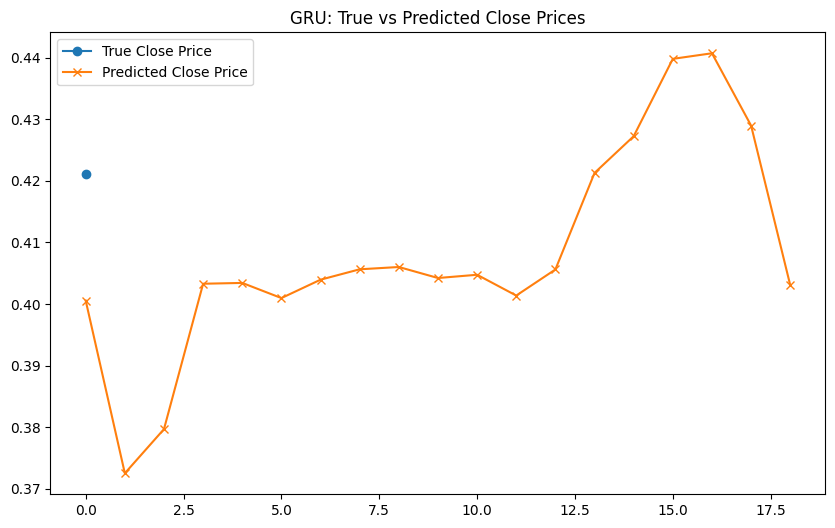

In [18]:
# Plot true vs predicted values for the 'Close' feature
gru_true_close = y_test.reshape(-1, 5)[:, 3]  # Extract true 'Close' values
gru_pred_close = gru_y_pred.reshape(-1, 5)[:, 3]  # Extract predicted 'Close' values

plt.figure(figsize=(10, 6))
plt.plot(gru_true_close, label='True Close Price', marker='o')
plt.plot(gru_pred_close, label='Predicted Close Price', marker='x')
plt.title('GRU: True vs Predicted Close Prices')
plt.legend()
plt.show()

## Implement LSTM Model

In [19]:
from keras.layers import LSTM

# Define the LSTM model
def build_lstm(sequence_length, num_features):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dense(units=5))  # Output layer for 5 features
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the model
lstm_model = build_lstm(sequence_length=19, num_features=5)

# Display the model summary
lstm_model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 19, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 19, 5)          │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,455 (44.75 KB)

 Trainable params: 11,455 (44.75 KB)

 Non-trainable params: 0 (0.00 B)

### Train the LSTM Model

In [20]:
# Train the LSTM model
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.1,  # Use 10% of training data for validation
    epochs=20,
    batch_size=32,
    verbose=0
)

### Evaluate the LSTM Model

In [21]:
# Evaluate the model on test data
lstm_test_loss = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Test Loss: {lstm_test_loss}")

# Make predictions
lstm_y_pred = lstm_model.predict(X_test)

# Rescale the predictions (if necessary)
lstm_y_pred_rescaled = scaler.inverse_transform(lstm_y_pred.reshape(-1, 5))

print("\nLSTM Rescaled Predictions:")
print(lstm_y_pred_rescaled)

LSTM Test Loss: 0.0017136352835223079
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

LSTM Rescaled Predictions:
[[6.9943213e+02 7.2225818e+02 6.8577893e+02 7.3012048e+02 1.9913906e+06]
 [7.8095197e+02 7.9697906e+02 7.7054126e+02 7.8031787e+02 1.3600120e+06]
 [7.7934247e+02 7.9125568e+02 7.6897852e+02 7.7392444e+02 1.1246799e+06]
 [7.8743091e+02 7.9895148e+02 7.7714221e+02 7.6975232e+02 1.1942968e+06]
 [7.9721698e+02 8.0971210e+02 7.8882251e+02 7.6891718e+02 1.2933559e+06]
 [8.0034735e+02 8.1313159e+02 7.9441626e+02 7.7105219e+02 1.4013310e+06]
 [8.0007635e+02 8.1267981e+02 7.9661755e+02 7.7704974e+02 1.4936618e+06]
 [7.9950604e+02 8.1187720e+02 7.9831757e+02 7.8357990e+02 1.5573940e+06]
 [8.0076880e+02 8.1366272e+02 8.0185828e+02 7.8982916e+02 1.5742229e+06]
 [7.9715955e+02 8.0988605e+02 7.9980286e+02 7.9346985e+02 1.6036920e+06]
 [7.9559406e+02 8.0838843e+02 7.9954663e+02 7.9718604e+02 1.6171409e+06]
 [7.9458569e+02 8.0773151e+02 7.9992426e+02 7.9827673e+02 1.6130275e+06]
 [7.9445319e+02 8.07

### Visualize LSTM Results

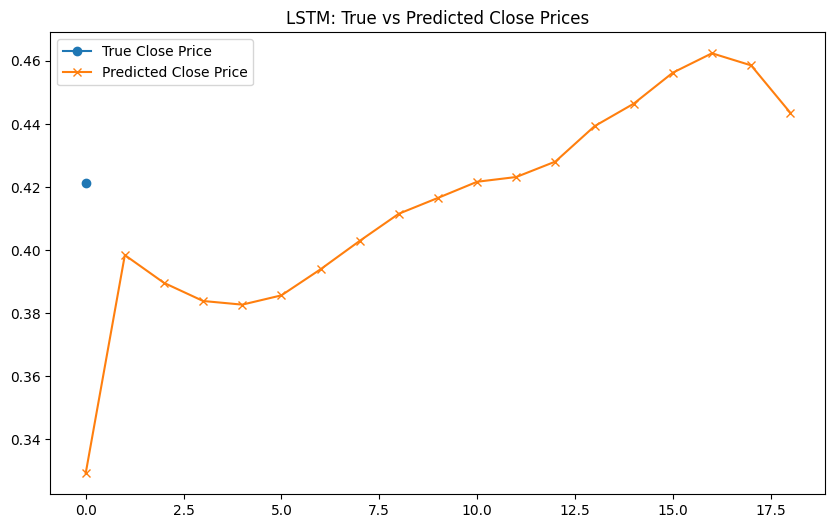

In [22]:
# Plot true vs predicted values for the 'Close' feature
lstm_true_close = y_test.reshape(-1, 5)[:, 3]  # Extract true 'Close' values
lstm_pred_close = lstm_y_pred.reshape(-1, 5)[:, 3]  # Extract predicted 'Close' values

plt.figure(figsize=(10, 6))
plt.plot(lstm_true_close, label='True Close Price', marker='o')
plt.plot(lstm_pred_close, label='Predicted Close Price', marker='x')
plt.title('LSTM: True vs Predicted Close Prices')
plt.legend()
plt.show()